# 1. Cas de charge "lac plein"

On importe les fonctions permettant de gérer le maillage, la visualisation et la définition du problème. On utilisera `matplotlib` et `numpy` pour les tracés de valeurs. `ufl` fournit les différents opérateurs symboliques permettant de définir le problème (voir [ici pour plus de détails](documentation.ipynb#Opérateurs-symboliques-ufl)).

In [2]:
from meshing import generate_3D_mesh, generate_2D_mesh, generate_2D_cracked_mesh
from plotting import plot_mesh, plot_def, plot_stress, plot_over_line
from problem import elastic_problem, integrate
import matplotlib.pyplot as plt
import numpy as np
from dolfinx import fem
from ufl import sym, grad, Identity, tr, inner, sqrt, Measure, FacetNormal, SpatialCoordinate

On génére le type de maillage (2D/3D, taille de maille) que l'on souhaite. On récupère les informations correspondantes et on l'affiche. Notez que l'on a accès ici au vecteur normal unitaire extérieur $\underline{n}$ du bord du domaine.

In [3]:
mesh_data = generate_2D_mesh(lcar=0.2)
#mesh_data = generate_3D_mesh(lcar=1, fix_extremities=True)
#y_crack = 25
#mesh_data = generate_2D_cracked_mesh(y_crack=y_crack, a_crack=1., lcar=0.5, refinement_ratio=0.05)

mesh, cell_markers, facet_markers = mesh_data
gdim = mesh.geometry.dim
n = FacetNormal(mesh)
dx = Measure("dx", domain=mesh)
ds = Measure("ds", domain=mesh, subdomain_data=facet_markers)

plot_mesh(mesh)

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, orientation_widget=True, sizing_mode='stretch_width')

On définit à présent les propriétés du matériau, la loi de comportement et les chargements. Les expressions de la force volumique $\underline{f}$ et de la pression de l'eau $p(y)$ sont déjà fournies.

In [5]:
### A COMPLETER ###
material_data = {
    "E": 20*10**9.,       
    "nu": 0.2,
    "rho_g": 9.81*10**3,   
    "rhob_g": 23.5*10**3}

def epsilon(v):
    return sym(grad(v))

E, nu = material_data["E"], material_data["nu"]
lmbda = fem.Constant(mesh, E * nu / (1 + nu) / (1 - 2 * nu))
mu = fem.Constant(mesh, E / 2 / (1 + nu))
def sigma(eps):
    
    return (2*mu*eps + lmbda*tr(eps)*Identity(2))


weight = np.zeros((gdim,))
weight[1] = -material_data["rhob_g"]
# body force
f = fem.Constant(mesh, weight)


water_height = fem.Constant(mesh, 33.)
x = SpatialCoordinate(mesh)
ppos = lambda x: (x+abs(x))/2 # positive part function ppos(x) = x if x>0 else 0
# water pressure p(y) = rho*g*(H-y) if y<H
p = material_data["rho_g"]*ppos(water_height-x[1])


def Phi(v):
    
    return (inner(-p*n,v)*ds(4) + inner(f,v)*dx)

On résout ensuite le problème et on affiche les résultats.

In [6]:
u, sig, E_pot, u_max = elastic_problem(mesh_data, sigma, Phi, order=1)

plot_def(u, scale=1e3)

Potential energy: -1993.4656134193328
Maximum displacement: [ 0.00130671 -0.00046059]




VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='100...], orientation_widget=True, sizing_mode='stretch_width')

On observe une plus grande déformation au sommet atteignant 1 mm. Il est cohérent que la déformation se trouve à l'opposé de l'encastrement. 

In [7]:
plot_stress(sig[1,1], mesh)

Stress: (min) -607519.1002 -- 845117.3146 (max)


VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='101...], orientation_widget=True, sizing_mode='stretch_width')

Conformément à l'intuition, les contraintes sont très fortes positivement au niveau où la pression de l'eau est la plus forte (face 4, y=0 au pied du barrage), au niveau des discontinuités de la géométrie (lignes brisées sur faces 2 et 4), et au niveau de l'encastrement négativement ce qui retient le barrage (face 1). 
Etonnament, les contraintes sont aussi très élevées positivement sur la face 3 qui est supposée libre de contraintes.

Enfin, on peut tracer l'évolution de quantités d'intérêts sur une ligne à l'aide de `plot_over_line`.

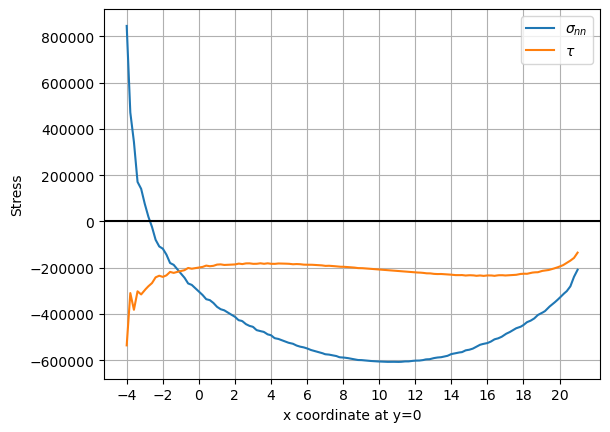

In [12]:
y = 0
pA = (-4, y)
pB = (21, y)
line = [pA, pB]
sig_n, points = plot_over_line(sig[1,1], line, mesh)
sig_c, points = plot_over_line(-sig[1,0], line, mesh)

x = points[:, 0]

plt.plot(x, sig_n, label=r"$\sigma_{nn}$")
plt.plot(x, sig_c, label=r"$\tau$")
plt.axhline(0, color='k')
plt.xticks(np.arange(pA[0], pB[0], 2))
plt.xlabel(f"x coordinate at y={y}")
plt.ylabel("Stress")
plt.legend()
plt.grid()


On a bien une forte contrainte normale positive au niveau de l'eau (traction), la géométrie inclinée pousse le barrage vers le sol par les forces de pression sur le barrage. On retrouve également une forte contrainte normale négative au milieu du barrage : le sol résiste au moment engendré par la pression de l'eau sur le barrage.

Le cisaillement est négatif, ce qui signifie que le sol retient le barrage de glisser.

Potential energy: -1993.4656134193328
Maximum displacement: [ 0.00130671 -0.00046059]


Potential energy: -1992.9018455103628
Maximum displacement: [ 0.00130689 -0.00046076]


Potential energy: -1991.9466785133882
Maximum displacement: [ 0.00130627 -0.00046101]


Potential energy: -1990.8043453139276
Maximum displacement: [ 0.00130571 -0.00046138]


Potential energy: -1989.4614563098935
Maximum displacement: [ 0.00130657 -0.00046183]


Potential energy: -1988.0039296277246
Maximum displacement: [ 0.00130485 -0.00046223]


Potential energy: -1985.9018461261917
Maximum displacement: [ 0.00130235 -0.0004626 ]


Potential energy: -1985.3797842226866
Maximum displacement: [ 0.00130842 -0.00046358]


Potential energy: -1982.4043073368116
Maximum displacement: [ 0.00129972 -0.00046405]


Potential energy: -1985.3344915887906
Maximum displacement: [ 0.00130637 -0.00046422]


Potential energy: -1979.0891226838144
Maximum displacement: [ 0.00130052 -0.00046503]


Potential energy: -1975.94214457

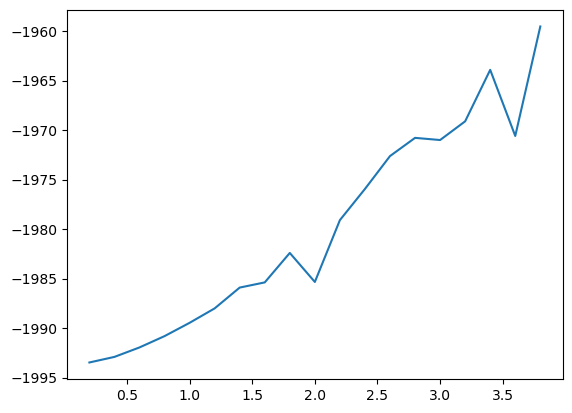

In [15]:
maillage =np.arange(0.2,4,0.2)
l=maillage.size
energie=np.zeros(l)

for i in range(l):
    mesh_data = generate_2D_mesh(lcar=maillage[i])
    mesh, cell_markers, facet_markers = mesh_data
    gdim = mesh.geometry.dim
    n = FacetNormal(mesh)
    dx = Measure("dx", domain=mesh)
    ds = Measure("ds", domain=mesh, subdomain_data=facet_markers)
    E, nu = material_data["E"], material_data["nu"]
    lmbda = fem.Constant(mesh, E * nu / (1 + nu) / (1 - 2 * nu))
    mu = fem.Constant(mesh, E / 2 / (1 + nu))
    weight = np.zeros((gdim,))
    weight[1] = -material_data["rhob_g"]
    # body force
    f = fem.Constant(mesh, weight)

    water_height = fem.Constant(mesh, 33.)
    x = SpatialCoordinate(mesh)
    ppos = lambda x: (x+abs(x))/2 # positive part function ppos(x) = x if x>0 else 0
    # water pressure p(y) = rho*g*(H-y) if y<H
    p = material_data["rho_g"]*ppos(water_height-x[1])
    u, sig, E_pot, u_max = elastic_problem(mesh_data, sigma, Phi, order=1)
    energie[i]=E_pot

plt.plot(maillage,energie)


# Cas de charge "lac vide"

$$\int_{\Omega} \underline{\underline{\sigma}}(\underline{\underline{\varepsilon}})^{el}:\underline{\underline{\widehat{\varepsilon}}} d\Omega= -\int_{\Omega} \underline{\underline{\sigma}}(\underline{\underline{\varepsilon}})^{th}:\underline{\underline{\widehat{\varepsilon}}}d\Omega + $$